# Cali Wildfire. EDA.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import optuna

# Initial EDA

In [29]:
cali = pd.read_csv('/Users/isaacfernandez/CaliWildfire/archive (3)/data.csv')

/var/folders/mz/9cypvzdn37g8034zbwdlq4g80000gn/T/ipykernel_9500/2680289039.py:1: DtypeWarning: Columns (13,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  cali = pd.read_csv('/Users/isaacfernandez/CaliWildfire/archive (3)/data.csv')


In [28]:
cali.columns

Index(['_id', 'OBJECTID', '* Damage', '* Street Number', '* Street Name',
       '* Street Type (e.g. road, drive, lane, etc.)',
       'Street Suffix (e.g. apt. 23, blding C)', '* City', 'State', 'Zip Code',
       '* CAL FIRE Unit', 'County', 'Community', 'Battalion',
       '* Incident Name', 'Incident Number (e.g. CAAEU 123456)',
       'Incident Start Date', 'Hazard Type',
       'If Affected 1-9% - Where did fire start?',
       'If Affected 1-9% - What started fire?',
       'Structure Defense Actions Taken', '* Structure Type',
       'Structure Category', '# Units in Structure (if multi unit)',
       '# of Damaged Outbuildings < 120 SQFT',
       '# of Non Damaged Outbuildings < 120 SQFT', '* Roof Construction',
       '* Eaves', '* Vent Screen', '* Exterior Siding', '* Window Pane',
       '* Deck/Porch On Grade', '* Deck/Porch Elevated',
       '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Distance - Propane Tank to Structure',
    

In [5]:
# Columns with more than 50% missing values
missing_values = cali.isnull().sum()
missing_values[missing_values > len(cali) * 0.5]

Street Suffix (e.g. apt. 23, blding C)                          56082
Zip Code                                                        52801
Battalion                                                       93832
If Affected 1-9% - Where did fire start?                        89490
If Affected 1-9% - What started fire?                           91214
Structure Defense Actions Taken                                 75760
# Units in Structure (if multi unit)                            69046
# of Damaged Outbuildings < 120 SQFT                            69145
# of Non Damaged Outbuildings < 120 SQFT                        69157
Distance - Propane Tank to Structure                            77173
Distance - Residence to Utility/Misc Structure &gt; 120 SQFT    85874
Fire Name (Secondary)                                           79059
dtype: int64

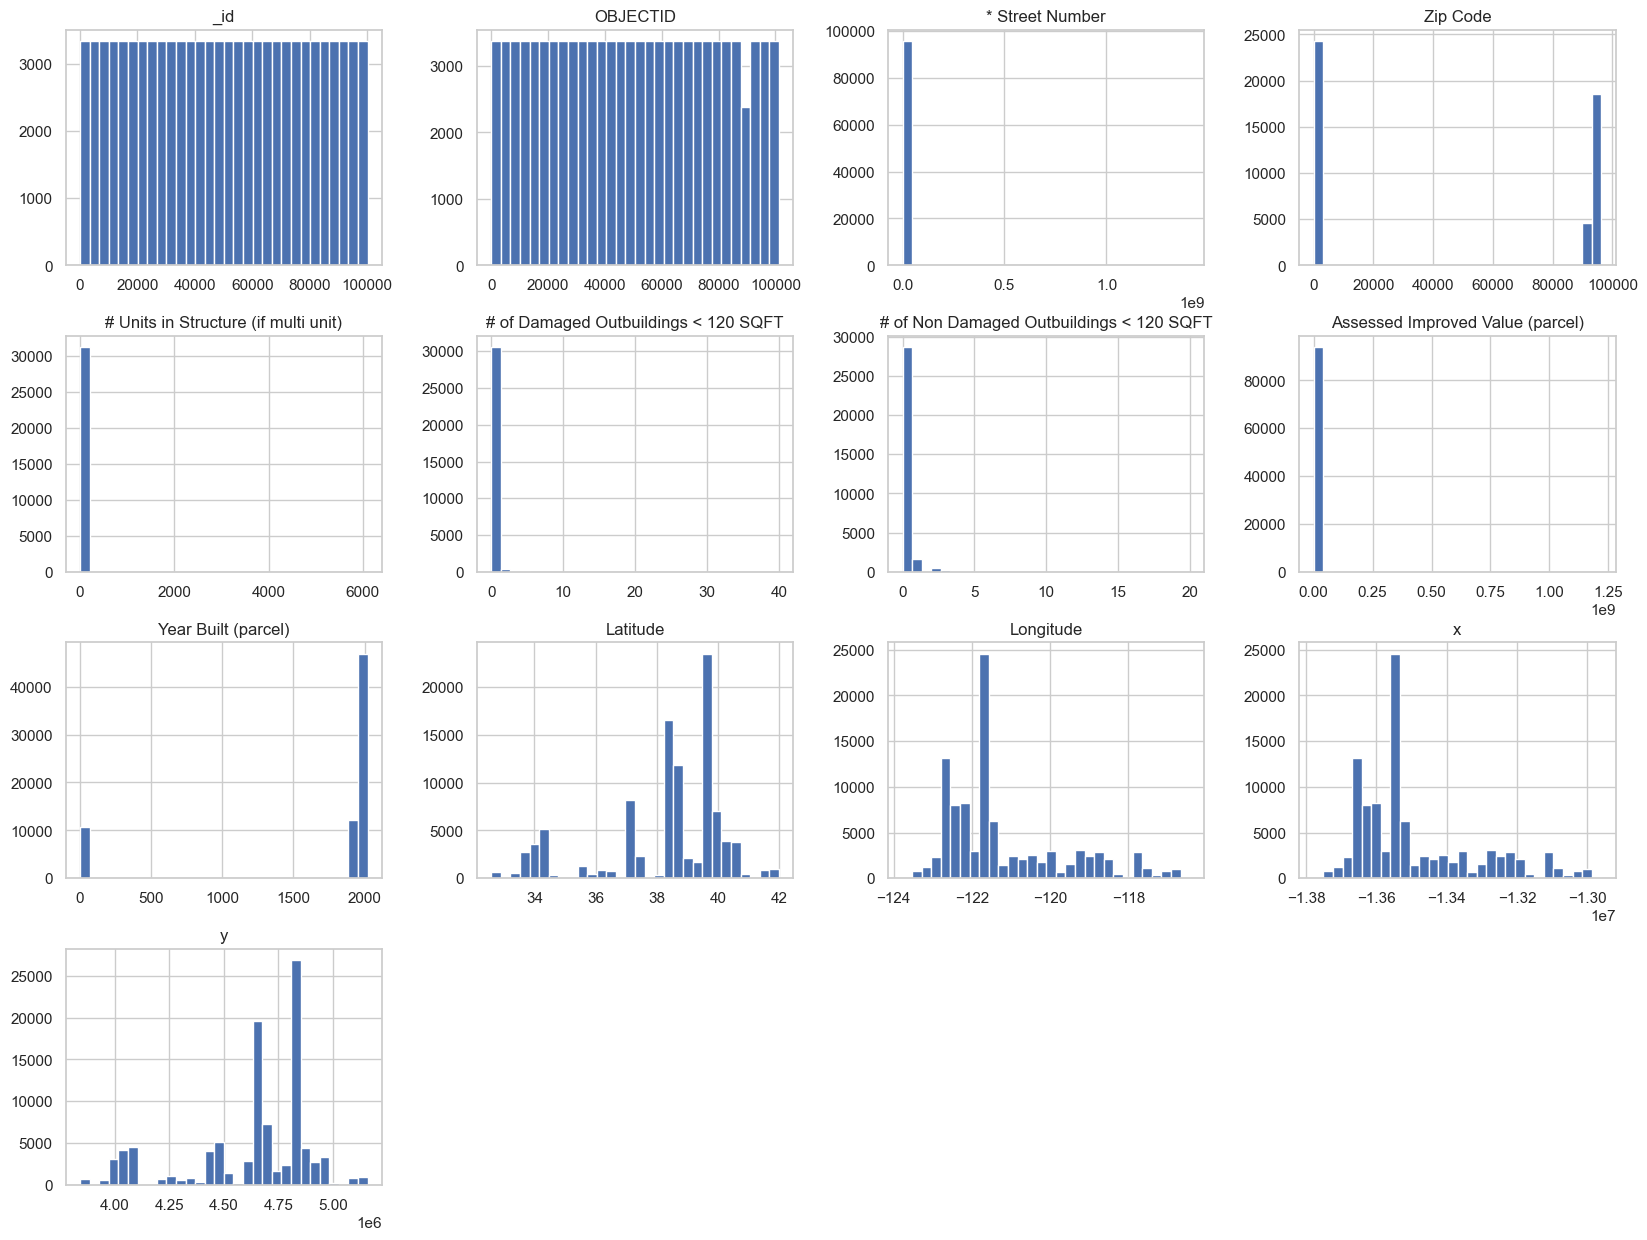

In [10]:

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Plot histograms for numerical columns
cali.hist(bins=30, figsize=(20, 15))
plt.show()

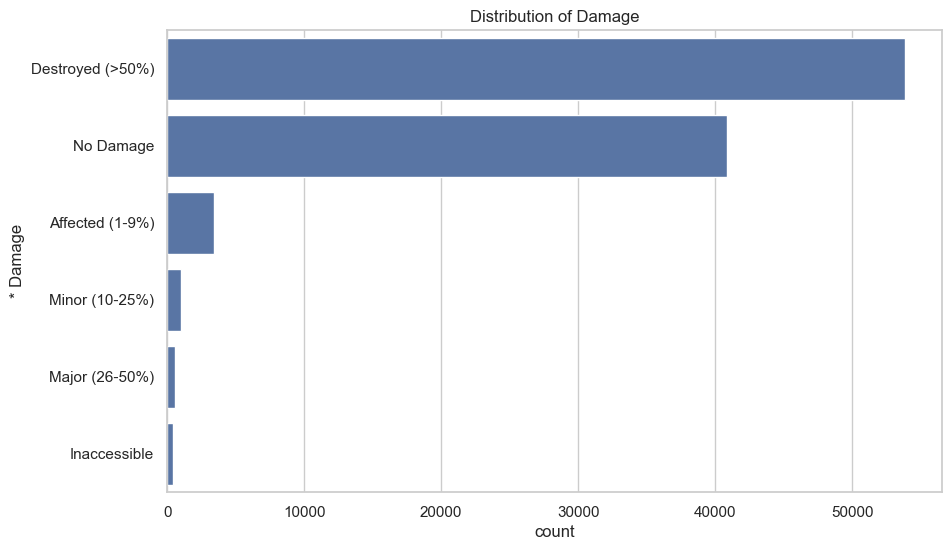

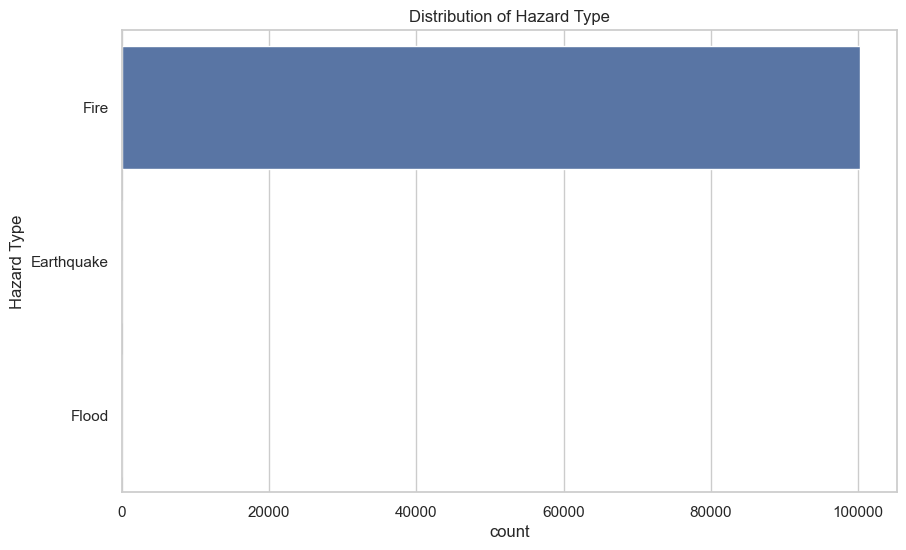

In [15]:
# Plot the distribution of the 'Damage' column
plt.figure(figsize=(10, 6))
sns.countplot(y='* Damage', data=cali, order=cali['* Damage'].value_counts().index)
plt.title('Distribution of Damage')
plt.show()

# Plot the distribution of the 'Hazard Type' column
plt.figure(figsize=(10, 6))
sns.countplot(y='Hazard Type', data=cali, order=cali['Hazard Type'].value_counts().index)
plt.title('Distribution of Hazard Type')
plt.show()

In [16]:
cali.head(2)

,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,...,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y
0,1,1,No Damage,8376.0,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06
1,2,2,Affected (1-9%),8402.0,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06


### Corr matrix

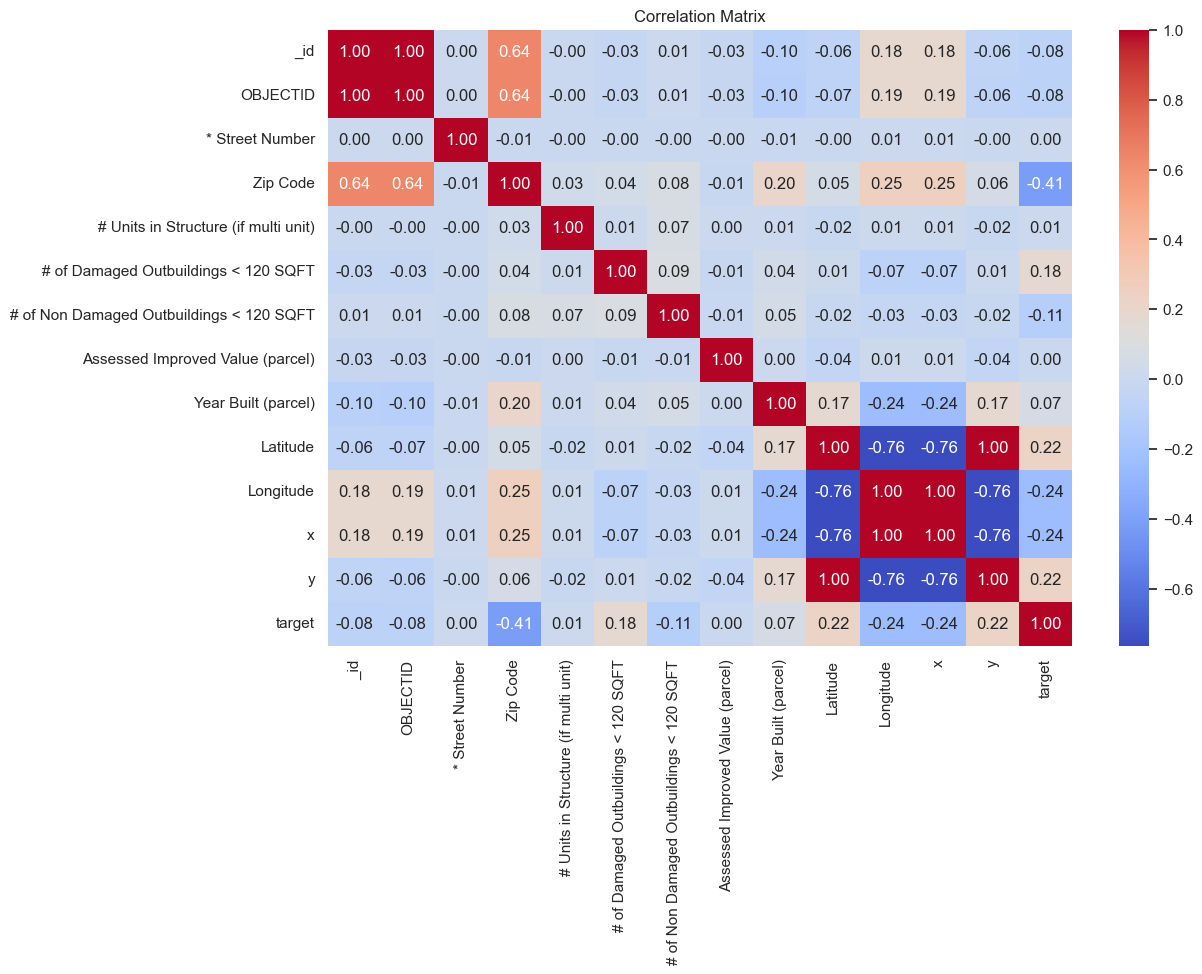

In [82]:
# Select numeric columns only
numeric_cali = cali.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr = numeric_cali.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


# Predicting Damage

In [32]:
# Convert to numeric, coercing errors to NaN
cali['* Street Number'] = pd.to_numeric(cali['* Street Number'], errors='coerce')

# Convert to Int64 (optional, to use nullable integer type)
cali['* Street Number'] = cali['* Street Number'].astype('Int64')

In [36]:
cali

,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,...,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y
0,1,1,No Damage,8376,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06
1,2,2,Affected (1-9%),8402,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06
2,3,3,No Damage,8430,Quail Canyon,Road,NaN,Winters,CA,NaN,...,Quail,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,-1.358594e+07,4.647366e+06
3,4,4,No Damage,3838,Putah Creek,Road,NaN,Winters,CA,NaN,...,Quail,0103010240,134880.0,1981.0,3838 PUTAH CREEK RD WINTERS CA 95694,64d4a278-5ee9-414a-8bf4-247c5b5c60f9,38.487313,-122.015115,-1.358266e+07,4.648497e+06
4,5,5,No Damage,3830,Putah Creek,Road,NaN,Winters,CA,NaN,...,Quail,0103010220,346648.0,1980.0,3830 PUTAH CREEK RD WINTERS CA 95694,1b44b214-01fd-4f06-b764-eb42a1ec93d7,38.485636,-122.016122,-1.358277e+07,4.648259e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100225,100226,101217,No Damage,24198,Case,Court,blding A,Malibu,CA,90265.0,...,NaN,4458018039.0,2249521.0,0.0,"24198 CASE CT, MALIBU, CA 90265",1b537de2-8b97-43ee-9d5c-c5a426f604f1,34.033408,-118.700625,-1.321369e+07,4.033289e+06
100226,100227,101218,No Damage,24198,Case,Court,blding B,Malibu,CA,90265.0,...,NaN,4458018039.0,2249521.0,0.0,"24198 CASE CT, MALIBU, CA 90265",56e3cc8b-4bf0-4beb-bd26-b54422cc31ee,34.033278,-118.700902,-1.321372e+07,4.033271e+06
100227,100228,101219,No Damage,24198,Case,Court,blding C,Malibu,CA,90265.0,...,NaN,4458018039.0,2249521.0,0.0,"24198 CASE CT, MALIBU, CA 90265",f85e9f02-a67f-4a7d-9fa1-0b8bf419d51a,34.033618,-118.701102,-1.321375e+07,4.033317e+06
100228,100229,101220,No Damage,24008,Malibu,Road,NaN,Malibu,CA,90265.0,...,NaN,4458009014.0,5983875.0,2016.0,"24008 MALIBU RD, MALIBU, CA 90265",51b2df1f-852e-4f36-b250-b383c93e4042,34.032085,-118.698270,-1.321343e+07,4.033111e+06


In [37]:
Y_var = cali[['_id','* Damage']]

In [43]:
Y_var['* Damage'].unique()

array(['No Damage', 'Affected (1-9%)', 'Minor (10-25%)',
       'Destroyed (>50%)', 'Major (26-50%)', 'Inaccessible'], dtype=object)

## One hot encoding

Notice something about the target variable? We have two categories in target which are "similar" in a sense. Since they are not a part of any of the other mappings. "no damage" and "inaccessible" we will put them together to reduce noise. Since they **don't follow a progressive order** 

In [103]:

ordinal_mapping = {
    'No Damage': 0,
    'Inaccessible': 0,  # Combine with "No Damage"
    'Affected (1-9%)': 1,
    'Minor (10-25%)': 2,
    'Major (26-50%)': 3,
    'Destroyed (>50%)': 4
}

cali['target'] = cali['* Damage'].map(ordinal_mapping)


In [55]:
cali.sample(10) 
##Could it be possible that we have a biased target variable?


,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,...,APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y,target
86655,86656,86656,Destroyed (>50%),5790,N Arm,Road,C,Taylorsville,CA,95983.0,...,004230017,92793.0,NaN,5790 N ARM RD TAYLORSVILLE CA 95983,ad5e50b0-d17d-46c2-9965-8cd4d1ea0e47,40.143430,-120.793036,-1.344662e+07,4.886807e+06,4
68422,68423,68423,Destroyed (>50%),0,Mt. Veeder,Road,B,Unincorporated,CA,0.0,...,034360002000,96847.0,1946.0,3535 MOUNT VEEDER RD,47bad30c-1c46-4221-93f5-c39cdcc07f33,38.386624,-122.448164,-1.363087e+07,4.634188e+06,4
57597,57598,57598,No Damage,0,,NaN,NaN,Los Angeles,CA,0.0,...,4377020007,1385053.0,1962.0,1239 LINDA FLORA DR LOS ANGELES CA 90049,e03ec45d-7ab5-449e-996b-030f757298d0,34.093135,-118.466117,-1.318759e+07,4.041315e+06,0
19744,19745,19745,No Damage,5300,Monticello,Road,B,NaN,CA,NaN,...,032390004000,182442.0,1984.0,5300 MONTICELLO RD NAPA CA 94558,facbde02-7c01-41c1-9ee6-45ee9daaa616,38.432748,-122.202349,-1.360350e+07,4.640740e+06,0
86671,86672,86672,No Damage,3405,Diamond Mountain,Road,C,Greenville,CA,95947.0,...,004220021,139026.0,NaN,3405 DIAMOND MOUNTAIN RD GREENVILLE CA 95947,803c8566-71fa-4152-9ace-6009d087cc6d,40.141251,-120.820786,-1.344971e+07,4.886490e+06,0
68090,68091,68091,Destroyed (>50%),830,Hillside,Drive,0,Weed,CA,0.0,...,,60248.0,NaN,830 HILLSIDE DR,abf11191-aa4e-49f3-9508-c9080095ca9b,41.427689,-122.375921,-1.362283e+07,5.075632e+06,4
59914,59915,59915,Destroyed (>50%),3534,Santiago,Drive,NaN,Santa Rosa,CA,0.0,...,034-371-005,284000.0,NaN,3534 SANTIAGO DR SANTA ROSA CA 95403,23a75bc7-5790-4924-93c6-88fcf32351e3,38.476577,-122.751864,-1.366467e+07,4.646971e+06,4
84080,84081,84081,Destroyed (>50%),114,Crescent,Street,NaN,Greenville,CA,95947.0,...,110063018,206545.0,NaN,114 CRESCENT ST GREENVILLE CA 95947,f8539ee2-5e38-438d-bbf7-0052c7092607,40.139575,-120.950046,-1.346410e+07,4.886246e+06,4
69605,69606,69606,Destroyed (>50%),4966,Lakepointe,Circle,NaN,Santa Rosa,CA,0.0,...,173-740-006,360752.0,NaN,4966 LAKEPOINTE CIR SANTA ROSA CA 95403,f4416c83-ef56-4b2f-8789-feb24fe8ef35,38.490040,-122.718631,-1.366098e+07,4.648885e+06,4
47626,47627,47627,Destroyed (>50%),5811,Nielsen,Drive,B,Paradise Southeast A,CA,NaN,...,053-230-135-000,192474.0,1976.0,5811 NIELSEN DR PARADISE CA 95969,a92a341b-65be-4469-b4f5-9913cebb631b,39.757891,-121.586926,-1.353499e+07,4.830822e+06,4


In [63]:
# Encode categorical features (if any)
# categorical_cols = cali.select_dtypes(include=['object']).columns.tolist()
# for col in categorical_cols:
#     cali[col] = cali[col].astype('category')


cali.describe(include='all')






,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,* CAL FIRE Unit,County,Community,Battalion,* Incident Name,Incident Number (e.g. CAAEU 123456),Incident Start Date,Hazard Type,If Affected 1-9% - Where did fire start?,If Affected 1-9% - What started fire?,Structure Defense Actions Taken,* Structure Type,Structure Category,# Units in Structure (if multi unit),# of Damaged Outbuildings < 120 SQFT,# of Non Damaged Outbuildings < 120 SQFT,* Roof Construction,* Eaves,* Vent Screen,* Exterior Siding,* Window Pane,* Deck/Porch On Grade,* Deck/Porch Elevated,* Patio Cover/Carport Attached to Structure,* Fence Attached to Structure,Distance - Propane Tank to Structure,Distance - Residence to Utility/Misc Structure &gt; 120 SQFT,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y,target
count,100230.000000,100230.000000,100230,95810.0,94744,87033,44148,68616,100223,47429.000000,100230,100200,52892,6398,100230,100230,100230,100230,10740,9016,24470,100230,100230,31184.000000,31085.000000,31073.00000,99602,99118,99032,99321,99254,100230,100230,100230,78635,23057,14356,21171,99613,9.419500e+04,69812.000000,95591,100230,100230.000000,100230.000000,1.002300e+05,1.002300e+05,100230.000000
unique,NaN,NaN,6,<NA>,9820,27,2263,442,1,NaN,27,50,1001,30,270,294,294,3,18,9,10,19,7,NaN,NaN,NaN,11,6,10,11,7,6,6,5,4,6,6,23,56857,NaN,NaN,53338,100230,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Destroyed (>50%),<NA>,Pentz,Road,A,Unincorporated,CA,NaN,BTU,Butte,Paradise,5,Camp,CABTU 016737,11/8/2018 12:00:00 AM,Fire,Unknown,Unknown,Unknown,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Asphalt,Unknown,Unknown,Wood,Multi Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,No Fence,Unknown,<30',CZU Lightning Complex,018060086000,NaN,NaN,,e1919a06-b4c6-476d-99e5-f0b45b070de8,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,53879,<NA>,750,42228,13343,16201,100223,NaN,28774,28715,7457,1727,23624,23624,25637,100228,8551,5666,17894,33692,65520,NaN,NaN,NaN,37496,39588,31912,24266,33801,30317,43227,40854,46200,6646,7049,4820,258,NaN,NaN,1850,1,NaN,NaN,NaN,NaN,NaN
mean,50115.500000,50227.779717,NaN,38867.218923,NaN,NaN,NaN,NaN,NaN,46309.699973,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.433299,0.087566,0.12152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.337022e+05,1672.283862,NaN,NaN,38.322953,-121.179297,-1.348962e+07,4.629002e+06,2.243460
std,28934.053078,29107.678335,NaN,5271694.85755,NaN,NaN,NaN,NaN,NaN,47467.653484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.608767,0.462729,0.52558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.603013e+06,708.451814,NaN,NaN,2.019086,1.538342,1.712474e+05,2.825063e+05,1.949898
min,1.000000,1.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,NaN,NaN,32.592548,-123.774580,-1.377852e+07,3.841346e+06,0.000000
25%,25058.250000,25058.250000,NaN,723.25,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.937000e+04,1944.000000,NaN,NaN,37.350926,-122.316162,-1.361617e+07,4.488135e+06,0.000000
50%,50115.500000,50115.500000,NaN,4308.5,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.455510e+05,1972.000000,NaN,NaN,38.692955,-121.600277,-1.353648e+07,4.677785e+06,4.000000
75%,75172.750000,75172.750000,NaN,10003.0,NaN,NaN,NaN,NaN,NaN,95667.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.109355e+05,1987.000000,NaN,NaN,39.763874,-120.509278,-1.341503e+07,4.831688e+

## Understanding features

In [66]:
for column in cali.columns:
    print(f"Unique values in {column}:")
    print(cali[column].unique()[:10])  # Display the first 10 unique values
    print("\n")


Unique values in _id:
[ 1  2  3  4  5  6  7  8  9 10]


Unique values in OBJECTID:
[ 1  2  3  4  5  6  7  8  9 10]


Unique values in * Damage:
['No Damage' 'Affected (1-9%)' 'Minor (10-25%)' 'Destroyed (>50%)'
 'Major (26-50%)' 'Inaccessible']


Unique values in * Street Number:
<IntegerArray>
[8376, 8402, 8430, 3838, 3830, 3834, 3806, 3749, 3786, 3778]
Length: 10, dtype: Int64


Unique values in * Street Name:
['Quail Canyon' 'Quail Canyon ' 'Putah Creek' 'Putah creek '
 'Pleasants Valley' 'Pleasants valley ' 'Olive School ' 'Olive School'
 'Coyote Hill' 'Eucalyptus ']


Unique values in * Street Type (e.g. road, drive, lane, etc.):
['Road' 'Lane' 'Other' 'Trail' 'Drive' 'Street' nan 'Way' 'Avenue' 'Court']


Unique values in Street Suffix (e.g. apt. 23, blding C):
[nan 'B' 'Building B' 'Building A' 'Building C' 'D' 'E' 'F' 'G' 'H']


Unique values in * City:
['Winters' 'Winters ' 'RAncho Cordova' 'Oroville' 'Pismo Beach' 'Dorris'
 'Macdoel' 'Gilroy' 'Bangor ' 'Bangor']


Unique valu

In [67]:
cali.head(5)

,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,* CAL FIRE Unit,County,Community,Battalion,* Incident Name,Incident Number (e.g. CAAEU 123456),Incident Start Date,Hazard Type,If Affected 1-9% - Where did fire start?,If Affected 1-9% - What started fire?,Structure Defense Actions Taken,* Structure Type,Structure Category,# Units in Structure (if multi unit),# of Damaged Outbuildings < 120 SQFT,# of Non Damaged Outbuildings < 120 SQFT,* Roof Construction,* Eaves,* Vent Screen,* Exterior Siding,* Window Pane,* Deck/Porch On Grade,* Deck/Porch Elevated,* Patio Cover/Carport Attached to Structure,* Fence Attached to Structure,Distance - Propane Tank to Structure,Distance - Residence to Utility/Misc Structure &gt; 120 SQFT,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,x,y,target
0,1,1,No Damage,8376,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,8.0,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Multi Story,Single Residence,1.0,NaN,NaN,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Single Pane,Wood,Wood,No Patio Cover/Carport,No Fence,NaN,NaN,Quail,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,-1.358593e+07,4.646741e+06,0
1,2,2,Affected (1-9%),8402,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,NaN,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,Deck on Grade,Unknown,Hand Crew Fuel Break,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Multi Pane,Masonry/Concrete,No Deck/Porch,No Patio Cover/Carport,Combustible,NaN,NaN,Quail,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,-1.358579e+07,4.647094e+06,1
2,3,3,No Damage,8430,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,NaN,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Asphalt,Enclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,No Fence,NaN,NaN,Quail,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,-1.358594e+07,4.647366e+06,0
3,4,4,No Damage,3838,Putah Creek,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,NaN,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Asphalt,Unenclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,Combustible,No Fence,NaN,NaN,Quail,0103010240,134880.0,1981.0,3838 PUTAH CREEK RD WINTERS CA 95694,64d4a278-5ee9-414a-8bf4-247c5b5c60f9,38.487313,-122.015115,-1.358266e+07,4.648497e+06,0
4,5,5,No Damage,3830,Putah Creek,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,NaN,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Tile,Enclosed,"Mesh Screen > 1/8""""",Wood,Multi Pane,Wood,Wood,Combustible,No Fence,NaN,NaN,Quail,0103010220,346648.0,1980.0,3830 PUTAH CREEK RD WINTERS CA 95694,1b44b214-01fd-4f06-b764-eb42a1ec93d7,38.485636,-122.016122,-1.358277e+07,4.648259e+06,0


In [68]:
cali.columns

Index(['_id', 'OBJECTID', '* Damage', '* Street Number', '* Street Name',
       '* Street Type (e.g. road, drive, lane, etc.)',
       'Street Suffix (e.g. apt. 23, blding C)', '* City', 'State', 'Zip Code',
       '* CAL FIRE Unit', 'County', 'Community', 'Battalion',
       '* Incident Name', 'Incident Number (e.g. CAAEU 123456)',
       'Incident Start Date', 'Hazard Type',
       'If Affected 1-9% - Where did fire start?',
       'If Affected 1-9% - What started fire?',
       'Structure Defense Actions Taken', '* Structure Type',
       'Structure Category', '# Units in Structure (if multi unit)',
       '# of Damaged Outbuildings < 120 SQFT',
       '# of Non Damaged Outbuildings < 120 SQFT', '* Roof Construction',
       '* Eaves', '* Vent Screen', '* Exterior Siding', '* Window Pane',
       '* Deck/Porch On Grade', '* Deck/Porch Elevated',
       '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Distance - Propane Tank to Structure',
    

## Selecting features

/var/folders/mz/9cypvzdn37g8034zbwdlq4g80000gn/T/ipykernel_9500/3802746103.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cali, y='* Structure Type', ax=axes[0, 0], palette='plasma')
/var/folders/mz/9cypvzdn37g8034zbwdlq4g80000gn/T/ipykernel_9500/3802746103.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cali, y='* Roof Construction', ax=axes[0, 1], palette='cividis')
/var/folders/mz/9cypvzdn37g8034zbwdlq4g80000gn/T/ipykernel_9500/3802746103.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cali, y='* CAL FI

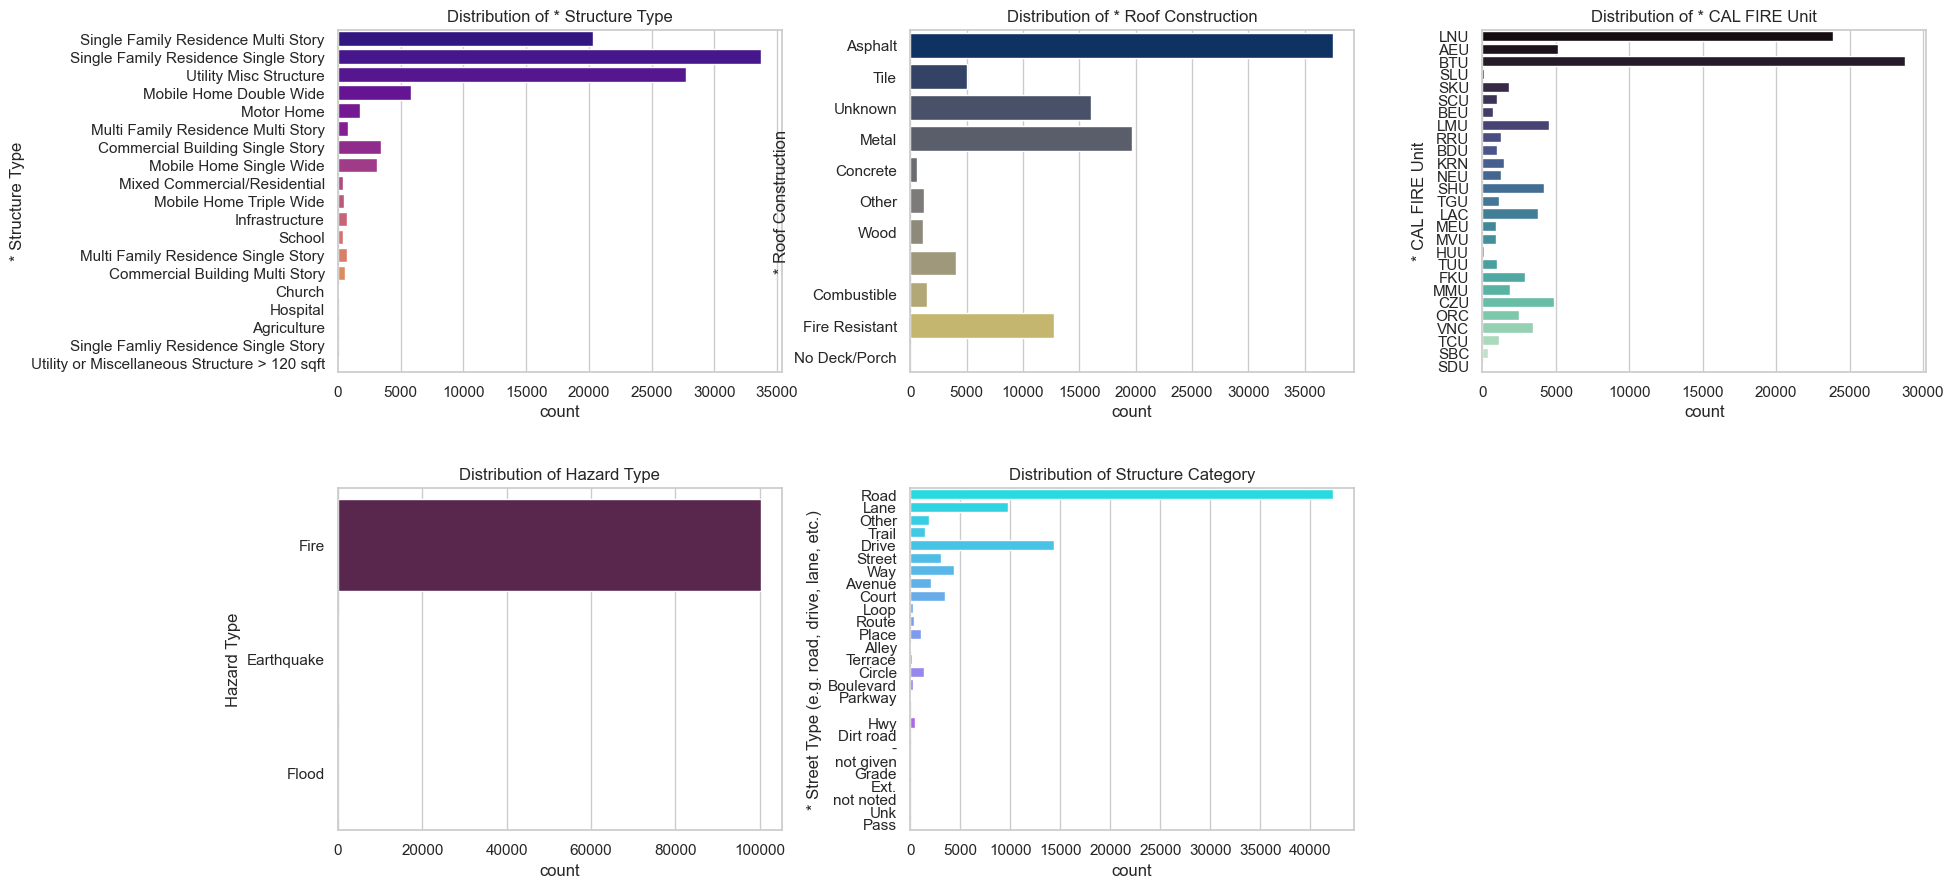

In [76]:
# Selecting an additional variable for visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.tight_layout(pad=5.0)

# Graph 1: * Structure Type
sns.countplot(data=cali, y='* Structure Type', ax=axes[0, 0], palette='plasma')
axes[0, 0].set_title('Distribution of * Structure Type')

# Graph 2: * Roof Construction
sns.countplot(data=cali, y='* Roof Construction', ax=axes[0, 1], palette='cividis')
axes[0, 1].set_title('Distribution of * Roof Construction')

# Graph 3: * CAL FIRE Unit
sns.countplot(data=cali, y='* CAL FIRE Unit', ax=axes[0, 2], palette='mako')
axes[0, 2].set_title('Distribution of * CAL FIRE Unit')

# Graph 4: Hazard Type
sns.countplot(data=cali, y='Hazard Type', ax=axes[1, 0], palette='rocket')
axes[1, 0].set_title('Distribution of Hazard Type')


sns.countplot(data=cali, y='* Street Type (e.g. road, drive, lane, etc.)', ax=axes[1, 1], palette='cool')
axes[1, 1].set_title('Distribution of Structure Category')

# Remove extra empty plot
fig.delaxes(axes[1, 2])

plt.show()


### Numerical features

In [81]:
cali.corr()

ValueError: could not convert string to float: 'No Damage'

## Understanding the target variable

/var/folders/mz/9cypvzdn37g8034zbwdlq4g80000gn/T/ipykernel_9500/1010894007.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=cali, y='* Damage', palette='rocket')


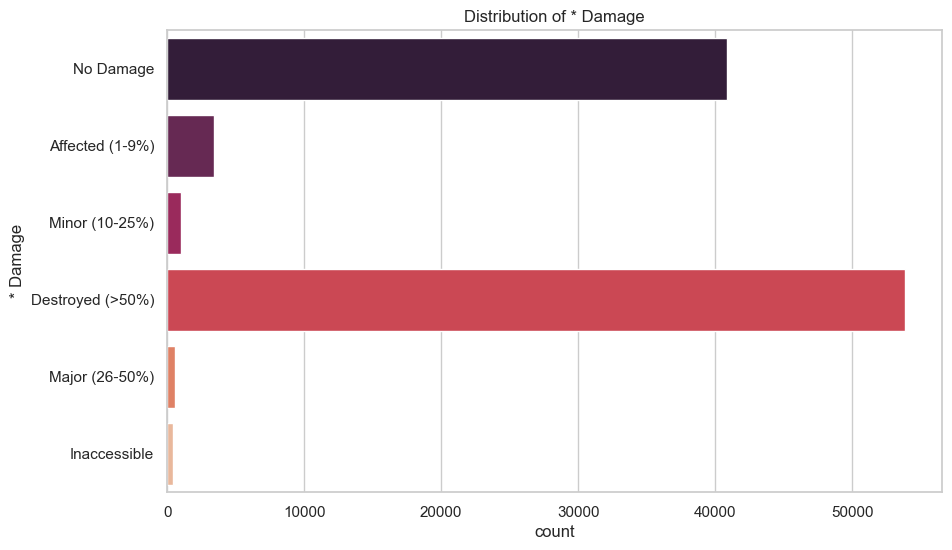

In [104]:
# Individual variable visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization of '* Damage'
plt.figure(figsize=(10, 6))
sns.countplot(data=cali, y='* Damage', palette='rocket')
plt.title('Distribution of * Damage')
plt.show()


We can realize that our target variable is *biased*! If we are trying to train any model with this data it will be biased towards the largest two categories, no damage/destroyed.

From here, we can either decide to turn this into binary target or, train accounting for the bias.


### Features relations with target variable

Lets first have a look to what features relate more to our target variable

## Numerical Variables

In [105]:
cali = cali.drop(labels=['x','y'],axis=1)

KeyError: "['x', 'y'] not found in axis"

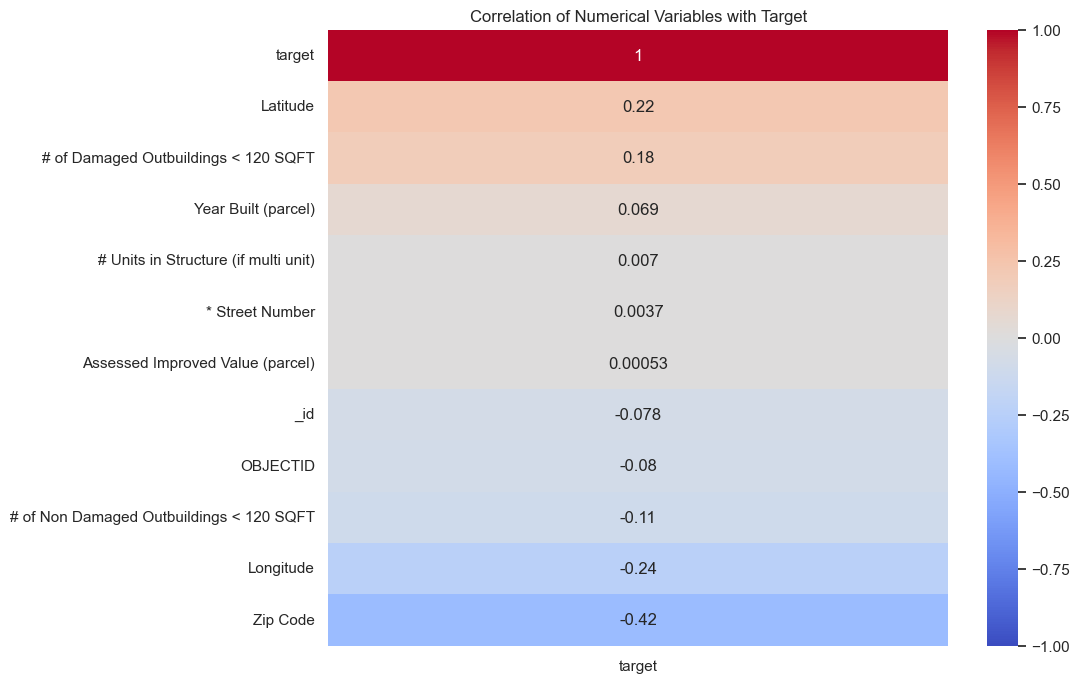

In [106]:
import numpy as np
# Select only numerical columns
numerical_cali = cali.select_dtypes(include=[np.number])

# Compute correlation
correlation_matrix = numerical_cali.corr()

# Visualize the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['target']].sort_values(by='target', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation of Numerical Variables with Target')
plt.show()



## Categorical variables

### Structure type

/var/folders/mz/9cypvzdn37g8034zbwdlq4g80000gn/T/ipykernel_9500/1928590233.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cali, x='target', y='* Structure Type', palette='viridis')


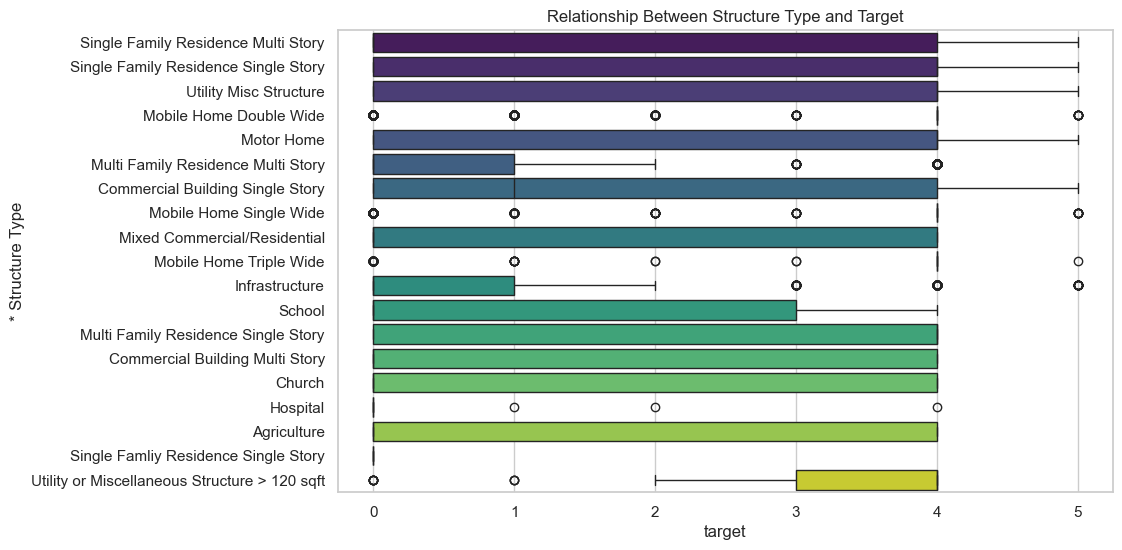

In [91]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=cali, x='target', y='* Structure Type', palette='viridis')
plt.title('Relationship Between Structure Type and Target')
plt.show()


In [98]:
len((cali[cali['* Damage'] == 'Inaccessible']).target)/cali.shape[0]


0.004349995011473611

### Assessed improved value

In [123]:
cali['Assessed Improved Value (parcel)'].astype(float)

np.float64(69111075160.0)

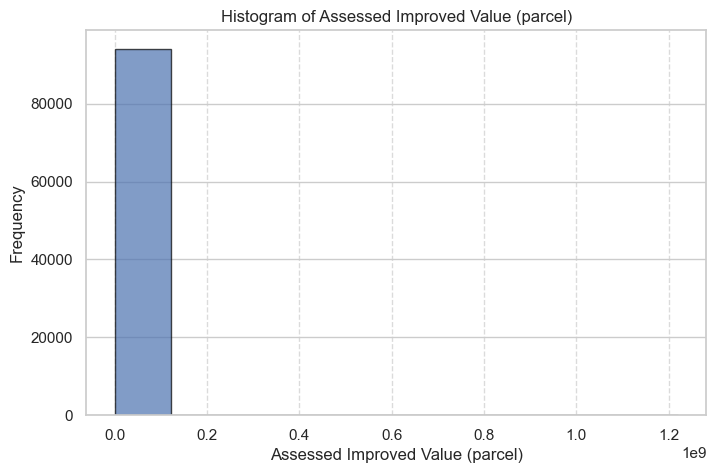

In [122]:
plt.figure(figsize=(8, 5))
plt.hist(cali['Assessed Improved Value (parcel)'].astype(float), bins=10, edgecolor='black', alpha=0.7)
plt.title('Histogram of Assessed Improved Value (parcel)')
plt.xlabel('Assessed Improved Value (parcel)')
plt.ylabel('Frequency')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [127]:
sample_values = cali['Assessed Improved Value (parcel)'].sample(50)



In [129]:
sample_values

19310      1174870.0
52996      7355943.0
81376       124848.0
50727       246909.0
801         210000.0
44111        51865.0
33085       179999.0
82956            NaN
29699       107513.0
84775       107161.0
62535       191678.0
18968        64757.0
39390       125842.0
8333             0.0
34378       102978.0
57471        20301.0
23646       191725.0
21489       232728.0
45600       765758.0
45136        77286.0
70069       100136.0
53010       159154.0
28185        57218.0
14839       698730.0
69325        52011.0
56504       230444.0
455         164466.0
7934        248535.0
68705        85000.0
41513       175018.0
44217       156779.0
79223        95345.0
24425        92331.0
79509       231901.0
52567    387390002.0
67445        29800.0
12704     48703108.0
79765       145714.0
70339       584272.0
43145        93829.0
87290       241249.0
19212        57245.0
47227       115000.0
9562         40786.0
93694            0.0
52931       520000.0
5068             0.0
40764        

Mean: 9227053.530612245
Median: 125842.0
Standard Deviation: 55589498.93875217


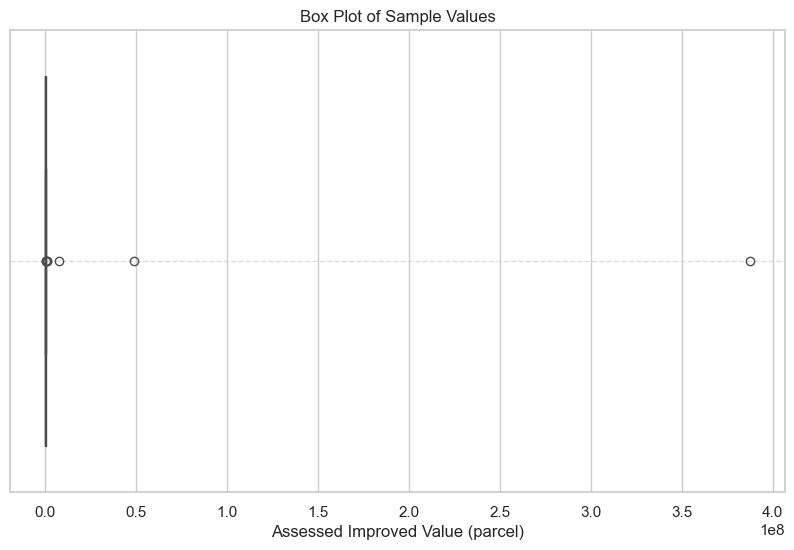

In [131]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=sample_values.dropna())
plt.title('Box Plot of Sample Values')
plt.xlabel('Assessed Improved Value (parcel)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
mean_value = sample_values.mean()
median_value = sample_values.median()
std_deviation = sample_values.std()

print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_deviation}")
plt.show()

This variable is heavily skewed to lower prices but contains outliers that account for large differences. First we will drop some outliers and then we will use a log transformation to account for the differences.

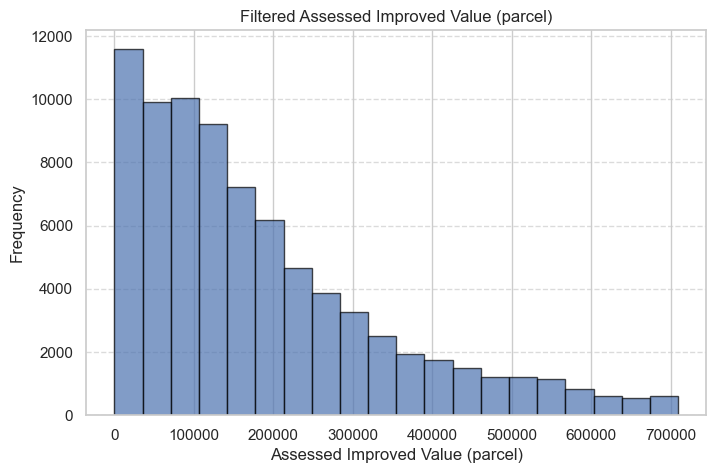

In [132]:
# Remove zeros and NaN values
filtered_values = cali['Assessed Improved Value (parcel)'].replace(0, np.nan).dropna()

# Calculate the IQR (Interquartile Range) for outlier detection
Q1 = filtered_values.quantile(0.25)
Q3 = filtered_values.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_values = filtered_values[(filtered_values >= lower_bound) & (filtered_values <= upper_bound)]






plt.figure(figsize=(8, 5))
plt.hist(filtered_values, bins=20, edgecolor='black', alpha=0.7)
plt.title('Filtered Assessed Improved Value (parcel)')
plt.xlabel('Assessed Improved Value (parcel)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

What does it look like ? Like a negative exponential distribution? Perhaps.

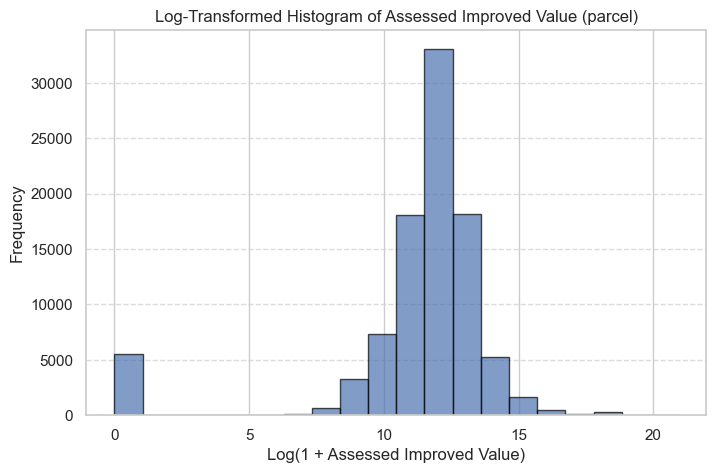

In [124]:
# Apply log transformation
log_values = np.log1p(cali['Assessed Improved Value (parcel)'])

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(log_values, bins=20, edgecolor='black', alpha=0.7)
plt.title('Log-Transformed Histogram of Assessed Improved Value (parcel)')
plt.xlabel('Log(1 + Assessed Improved Value)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


What does it look like? Like a normal distribution? Perhaps.

## LGBoost

## Initial model

In [135]:
cali['target'].unique()

array([0, 1, 2, 4, 3])

In [187]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import optuna

# Fixing mixed and non-numeric data
X = cali.select_dtypes(include=[np.number])
X= X.drop(columns=['target','_id','OBJECTID'])  # Use only numeric columns
y = cali['target']  # Ensure target is properly encoded

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM Datasets
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, free_raw_data=False)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 5,  # Number of classes
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,  # Correctly placed here
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'verbosity': -1,
        'random_state': 42
    }

    # Train the model
    model = lgb.train(
        params,
        train_data,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predict on the test set
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_model = lgb.train(
    {**best_params, 'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1},
    train_data,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# Evaluate the final model
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

[I 2025-02-11 17:19:25,632] A new study created in memory with name: no-name-171920c8-f2a9-454e-9987-2d857a204e1a
[I 2025-02-11 17:19:27,840] Trial 0 finished with value: 0.8477002893345306 and parameters: {'num_leaves': 164, 'learning_rate': 0.08562382314048707, 'min_child_samples': 31, 'max_depth': 5, 'reg_alpha': 0.9644312180794629, 'reg_lambda': 0.8160845081882151, 'subsample': 0.6655700002342323, 'colsample_bytree': 0.7793844311967058}. Best is trial 0 with value: 0.8477002893345306.
[I 2025-02-11 17:19:30,746] Trial 1 finished with value: 0.865509328544348 and parameters: {'num_leaves': 171, 'learning_rate': 0.16939473649878312, 'min_child_samples': 77, 'max_depth': 6, 'reg_alpha': 0.8472742828200689, 'reg_lambda': 0.2301938472428422, 'subsample': 0.7675073994036459, 'colsample_bytree': 0.6292948982960982}. Best is trial 1 with value: 0.865509328544348.
[I 2025-02-11 17:19:41,371] Trial 2 finished with value: 0.8779806445176095 and parameters: {'num_leaves': 180, 'learning_rate':

Best Hyperparameters: {'num_leaves': 177, 'learning_rate': 0.25568165124688935, 'min_child_samples': 18, 'max_depth': 11, 'reg_alpha': 0.5473524373999961, 'reg_lambda': 0.7767208828432497, 'subsample': 0.5461559069341078, 'colsample_bytree': 0.6733141993137651}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's multi_logloss: 0.393618
Accuracy: 0.8805746782400479
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      8261
           1       0.36      0.08      0.13       644
           2       0.17      0.03      0.06       206
           3       0.11      0.03      0.04       118
           4       0.90      0.91      0.90     10817

    accuracy                           0.88     20046
   macro avg       0.48      0.40      0.41     20046
weighted avg       0.86      0.88      0.87     20046



In [188]:
X_train

,* Street Number,Zip Code,# Units in Structure (if multi unit),# of Damaged Outbuildings < 120 SQFT,# of Non Damaged Outbuildings < 120 SQFT,Assessed Improved Value (parcel),Year Built (parcel),Latitude,Longitude
73298,0,0.0,NaN,NaN,NaN,0.0,NaN,36.390135,-121.836630
13289,3551,NaN,NaN,0.0,0.0,786502.0,1969.0,38.519103,-122.528957
66284,0,0.0,NaN,NaN,NaN,95000.0,NaN,38.820328,-122.698893
69027,10863,95470.0,NaN,NaN,NaN,217110.0,0.0,39.299452,-123.219295
70973,10149,0.0,NaN,NaN,NaN,0.0,1915.0,34.427130,-119.097124
...,...,...,...,...,...,...,...,...,...
6265,42220,0.0,0.0,0.0,0.0,0.0,0.0,37.111306,-119.322082
54886,<NA>,NaN,NaN,NaN,NaN,60835.0,1977.0,39.820737,-121.601992
76820,11867,NaN,NaN,NaN,NaN,NaN,NaN,41.581015,-122.312331
860,18390,0.0,0.0,0.0,0.0,45777.0,0.0,32.763139,-116.759951


In [173]:
y_train.value_counts()

target
4    43062
0    33070
1     2794
2      812
3      446
Name: count, dtype: int64

A couple of important remarks: If you closely examine the results, you'll notice that where we had more training data, we achieved higher precision and F1-scores. This shouldn’t be surprising, but it serves as a reminder of the challenges associated with ensemble methods—and machine learning in general. One key issue to watch for is target variable bias, where certain populations or classes have significantly more data than others. Addressing this imbalance is critical and can be approached in several ways, though I won’t be covering those methods here.

Though, we can improve this, either using hyperparameters search, regularization or feature selection.


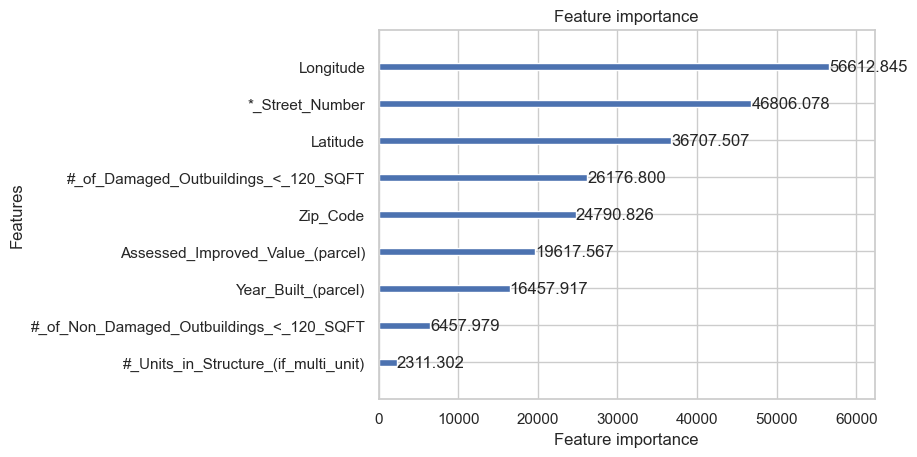

In [189]:
lgb.plot_importance(final_model, importance_type='gain', max_num_features=20)
plt.show()


In [185]:
print((X['_id'] == X['OBJECTID']).sum())
print(X.shape)

88874
(100230, 11)


## Adding features

In [191]:
cali.head(5)

,_id,OBJECTID,* Damage,* Street Number,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,Zip Code,* CAL FIRE Unit,County,Community,Battalion,* Incident Name,Incident Number (e.g. CAAEU 123456),Incident Start Date,Hazard Type,If Affected 1-9% - Where did fire start?,If Affected 1-9% - What started fire?,Structure Defense Actions Taken,* Structure Type,Structure Category,# Units in Structure (if multi unit),# of Damaged Outbuildings < 120 SQFT,# of Non Damaged Outbuildings < 120 SQFT,* Roof Construction,* Eaves,* Vent Screen,* Exterior Siding,* Window Pane,* Deck/Porch On Grade,* Deck/Porch Elevated,* Patio Cover/Carport Attached to Structure,* Fence Attached to Structure,Distance - Propane Tank to Structure,Distance - Residence to Utility/Misc Structure &gt; 120 SQFT,Fire Name (Secondary),APN (parcel),Assessed Improved Value (parcel),Year Built (parcel),Site Address (parcel),GLOBALID,Latitude,Longitude,target
0,1,1,No Damage,8376,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,8.0,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Multi Story,Single Residence,1.0,NaN,NaN,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Single Pane,Wood,Wood,No Patio Cover/Carport,No Fence,NaN,NaN,Quail,0101090290,510000.0,1997.0,8376 QUAIL CANYON RD VACAVILLE CA 95688,e1919a06-b4c6-476d-99e5-f0b45b070de8,38.474960,-122.044465,0
1,2,2,Affected (1-9%),8402,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,NaN,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,Deck on Grade,Unknown,Hand Crew Fuel Break,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Multi Pane,Masonry/Concrete,No Deck/Porch,No Patio Cover/Carport,Combustible,NaN,NaN,Quail,0101090270,573052.0,1980.0,8402 QUAIL CANYON RD VACAVILLE CA 95688,b090eeb6-5b18-421e-9723-af7c9144587c,38.477442,-122.043252,1
2,3,3,No Damage,8430,Quail Canyon,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,NaN,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Asphalt,Enclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,No Fence,NaN,NaN,Quail,0101090310,350151.0,2004.0,8430 QUAIL CANYON RD VACAVILLE CA 95688,268da70b-753f-46aa-8fb1-327099337395,38.479358,-122.044585,0
3,4,4,No Damage,3838,Putah Creek,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,NaN,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Asphalt,Unenclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,Combustible,No Fence,NaN,NaN,Quail,0103010240,134880.0,1981.0,3838 PUTAH CREEK RD WINTERS CA 95694,64d4a278-5ee9-414a-8bf4-247c5b5c60f9,38.487313,-122.015115,0
4,5,5,No Damage,3830,Putah Creek,Road,NaN,Winters,CA,NaN,LNU,Solano,NaN,NaN,Quail,CALNU 008419,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,NaN,NaN,NaN,Tile,Enclosed,"Mesh Screen > 1/8""""",Wood,Multi Pane,Wood,Wood,Combustible,No Fence,NaN,NaN,Quail,0103010220,346648.0,1980.0,3830 PUTAH CREEK RD WINTERS CA 95694,1b44b214-01fd-4f06-b764-eb42a1ec93d7,38.485636,-122.016122,0


In [192]:
cali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100230 entries, 0 to 100229
Data columns (total 46 columns):
 #   Column                                                        Non-Null Count   Dtype  
---  ------                                                        --------------   -----  
 0   _id                                                           100230 non-null  int64  
 1   OBJECTID                                                      100230 non-null  int64  
 2   * Damage                                                      100230 non-null  object 
 3   * Street Number                                               95810 non-null   Int64  
 4   * Street Name                                                 94744 non-null   object 
 5   * Street Type (e.g. road, drive, lane, etc.)                  87033 non-null   object 
 6   Street Suffix (e.g. apt. 23, blding C)                        44148 non-null   object 
 7   * City                                                  

In [200]:
categorical_cols = cali.select_dtypes(exclude=[np.number]).columns.tolist()
categorical_cols.remove('* Damage')
categorical_cols.remove('Incident Number (e.g. CAAEU 123456)')
categorical_cols.remove('GLOBALID')

In [202]:
print(len(categorical_cols) + len(X.columns)) 
print(len(cali.columns)) 
# we have dropped 6 columns so far...


40
46


In [206]:
cali['* Street Name'].nunique()

9820

### Adding Categorical Features

In [209]:
for col in categorical_cols:
    X[col] = cali[col].astype('category')


In [210]:
X

,* Street Number,Zip Code,# Units in Structure (if multi unit),# of Damaged Outbuildings < 120 SQFT,# of Non Damaged Outbuildings < 120 SQFT,Assessed Improved Value (parcel),Year Built (parcel),Latitude,Longitude,* Street Name,"* Street Type (e.g. road, drive, lane, etc.)","Street Suffix (e.g. apt. 23, blding C)",* City,State,* CAL FIRE Unit,County,Community,Battalion,* Incident Name,Incident Start Date,Hazard Type,If Affected 1-9% - Where did fire start?,If Affected 1-9% - What started fire?,Structure Defense Actions Taken,* Structure Type,Structure Category,* Roof Construction,* Eaves,* Vent Screen,* Exterior Siding,* Window Pane,* Deck/Porch On Grade,* Deck/Porch Elevated,* Patio Cover/Carport Attached to Structure,* Fence Attached to Structure,Distance - Propane Tank to Structure,Distance - Residence to Utility/Misc Structure &gt; 120 SQFT,Fire Name (Secondary),APN (parcel),Site Address (parcel)
0,8376,NaN,1.0,NaN,NaN,510000.0,1997.0,38.474960,-122.044465,Quail Canyon,Road,NaN,Winters,CA,LNU,Solano,NaN,8.0,Quail,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Multi Story,Single Residence,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Single Pane,Wood,Wood,No Patio Cover/Carport,No Fence,NaN,NaN,Quail,0101090290,8376 QUAIL CANYON RD VACAVILLE CA 95688
1,8402,NaN,NaN,NaN,NaN,573052.0,1980.0,38.477442,-122.043252,Quail Canyon,Road,NaN,Winters,CA,LNU,Solano,NaN,NaN,Quail,6/6/2020 12:00:00 AM,Fire,Deck on Grade,Unknown,Hand Crew Fuel Break,Single Family Residence Single Story,Single Residence,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Multi Pane,Masonry/Concrete,No Deck/Porch,No Patio Cover/Carport,Combustible,NaN,NaN,Quail,0101090270,8402 QUAIL CANYON RD VACAVILLE CA 95688
2,8430,NaN,NaN,NaN,NaN,350151.0,2004.0,38.479358,-122.044585,Quail Canyon,Road,NaN,Winters,CA,LNU,Solano,NaN,NaN,Quail,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,Asphalt,Enclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,No Fence,NaN,NaN,Quail,0101090310,8430 QUAIL CANYON RD VACAVILLE CA 95688
3,3838,NaN,NaN,NaN,NaN,134880.0,1981.0,38.487313,-122.015115,Putah Creek,Road,NaN,Winters,CA,LNU,Solano,NaN,NaN,Quail,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,Asphalt,Unenclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,Combustible,No Fence,NaN,NaN,Quail,0103010240,3838 PUTAH CREEK RD WINTERS CA 95694
4,3830,NaN,NaN,NaN,NaN,346648.0,1980.0,38.485636,-122.016122,Putah Creek,Road,NaN,Winters,CA,LNU,Solano,NaN,NaN,Quail,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,Tile,Enclosed,"Mesh Screen > 1/8""""",Wood,Multi Pane,Wood,Wood,Combustible,No Fence,NaN,NaN,Quail,0103010220,3830 PUTAH CREEK RD WINTERS CA 95694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100225,24198,90265.0,0.0,0.0,0.0,2249521.0,0.0,34.033408,-118.700625,Case,Court,blding A,Malibu,CA,LAC,Los Angeles,NaN,NaN,Franklin,12/9/2024 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,Metal,Enclosed,Unknown,Stucco Brick Cement,Multi Pane,Wood,No Deck/Porch,Non Combustible,No Fence,NaN,NaN,NaN,4458018039.0,"24198 CASE CT, MALIBU, CA 90265"
100226,24198,90265.0,0.0,0.0,0.0,2249521.0,0.0,34.033278,-118.700902,Case,Court,blding B,Malibu,CA,LAC,Los Angeles,NaN,NaN,Franklin,12/9/2024 12:00:00 AM,Fire,NaN,NaN,NaN,Utility Misc Structure,Other Minor Structure,Metal,No Eaves,Unknown,Stucco Brick Cement,Multi Pane,Masonry/Concrete,No Deck/Porch,No Patio Cover/Carport,No Fence,NaN,NaN,NaN,4458018039.0,"24198 CASE CT, MALIBU, CA 90265"
100227,24198,90265.0,0.0,0.0,0.0,2249521.0,0.0,34.033618,-118.701102,Case,Court,blding C,Malibu,CA,LAC,Los Angeles,NaN,NaN,Franklin,12/9/2024 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Stor

In [211]:
y

0         0
1         1
2         0
3         0
4         0
         ..
100225    0
100226    0
100227    0
100228    0
100229    0
Name: target, Length: 100230, dtype: int64

## Second model (Heavy model)

### Cleaning the names of the features

In [215]:
X.columns

Index(['* Street Number', 'Zip Code', '# Units in Structure (if multi unit)',
       '# of Damaged Outbuildings < 120 SQFT',
       '# of Non Damaged Outbuildings < 120 SQFT',
       'Assessed Improved Value (parcel)', 'Year Built (parcel)', 'Latitude',
       'Longitude', '* Street Name',
       '* Street Type (e.g. road, drive, lane, etc.)',
       'Street Suffix (e.g. apt. 23, blding C)', '* City', 'State',
       '* CAL FIRE Unit', 'County', 'Community', 'Battalion',
       '* Incident Name', 'Incident Start Date', 'Hazard Type',
       'If Affected 1-9% - Where did fire start?',
       'If Affected 1-9% - What started fire?',
       'Structure Defense Actions Taken', '* Structure Type',
       'Structure Category', '* Roof Construction', '* Eaves', '* Vent Screen',
       '* Exterior Siding', '* Window Pane', '* Deck/Porch On Grade',
       '* Deck/Porch Elevated', '* Patio Cover/Carport Attached to Structure',
       '* Fence Attached to Structure', 'Distance - Propane Tank to St

In [216]:
import re

# Rename columns by replacing special characters with underscores
X.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in X.columns]


In [217]:
X

,__Street_Number,Zip_Code,__Units_in_Structure__if_multi_unit_,__of_Damaged_Outbuildings___120_SQFT,__of_Non_Damaged_Outbuildings___120_SQFT,Assessed_Improved_Value__parcel_,Year_Built__parcel_,Latitude,Longitude,__Street_Name,__Street_Type__e_g__road__drive__lane__etc__,Street_Suffix__e_g__apt__23__blding_C_,__City,State,__CAL_FIRE_Unit,County,Community,Battalion,__Incident_Name,Incident_Start_Date,Hazard_Type,If_Affected_1_9____Where_did_fire_start_,If_Affected_1_9____What_started_fire_,Structure_Defense_Actions_Taken,__Structure_Type,Structure_Category,__Roof_Construction,__Eaves,__Vent_Screen,__Exterior_Siding,__Window_Pane,__Deck_Porch_On_Grade,__Deck_Porch_Elevated,__Patio_Cover_Carport_Attached_to_Structure,__Fence_Attached_to_Structure,Distance___Propane_Tank_to_Structure,Distance___Residence_to_Utility_Misc_Structure__gt__120_SQFT,Fire_Name__Secondary_,APN__parcel_,Site_Address__parcel_
0,8376,NaN,1.0,NaN,NaN,510000.0,1997.0,38.474960,-122.044465,Quail Canyon,Road,NaN,Winters,CA,LNU,Solano,NaN,8.0,Quail,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Multi Story,Single Residence,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Single Pane,Wood,Wood,No Patio Cover/Carport,No Fence,NaN,NaN,Quail,0101090290,8376 QUAIL CANYON RD VACAVILLE CA 95688
1,8402,NaN,NaN,NaN,NaN,573052.0,1980.0,38.477442,-122.043252,Quail Canyon,Road,NaN,Winters,CA,LNU,Solano,NaN,NaN,Quail,6/6/2020 12:00:00 AM,Fire,Deck on Grade,Unknown,Hand Crew Fuel Break,Single Family Residence Single Story,Single Residence,Asphalt,Unenclosed,"Mesh Screen <= 1/8""""",Wood,Multi Pane,Masonry/Concrete,No Deck/Porch,No Patio Cover/Carport,Combustible,NaN,NaN,Quail,0101090270,8402 QUAIL CANYON RD VACAVILLE CA 95688
2,8430,NaN,NaN,NaN,NaN,350151.0,2004.0,38.479358,-122.044585,Quail Canyon,Road,NaN,Winters,CA,LNU,Solano,NaN,NaN,Quail,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,Asphalt,Enclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,No Patio Cover/Carport,No Fence,NaN,NaN,Quail,0101090310,8430 QUAIL CANYON RD VACAVILLE CA 95688
3,3838,NaN,NaN,NaN,NaN,134880.0,1981.0,38.487313,-122.015115,Putah Creek,Road,NaN,Winters,CA,LNU,Solano,NaN,NaN,Quail,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,Asphalt,Unenclosed,"Mesh Screen > 1/8""""",Wood,Single Pane,No Deck/Porch,No Deck/Porch,Combustible,No Fence,NaN,NaN,Quail,0103010240,3838 PUTAH CREEK RD WINTERS CA 95694
4,3830,NaN,NaN,NaN,NaN,346648.0,1980.0,38.485636,-122.016122,Putah Creek,Road,NaN,Winters,CA,LNU,Solano,NaN,NaN,Quail,6/6/2020 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,Tile,Enclosed,"Mesh Screen > 1/8""""",Wood,Multi Pane,Wood,Wood,Combustible,No Fence,NaN,NaN,Quail,0103010220,3830 PUTAH CREEK RD WINTERS CA 95694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100225,24198,90265.0,0.0,0.0,0.0,2249521.0,0.0,34.033408,-118.700625,Case,Court,blding A,Malibu,CA,LAC,Los Angeles,NaN,NaN,Franklin,12/9/2024 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Single Residence,Metal,Enclosed,Unknown,Stucco Brick Cement,Multi Pane,Wood,No Deck/Porch,Non Combustible,No Fence,NaN,NaN,NaN,4458018039.0,"24198 CASE CT, MALIBU, CA 90265"
100226,24198,90265.0,0.0,0.0,0.0,2249521.0,0.0,34.033278,-118.700902,Case,Court,blding B,Malibu,CA,LAC,Los Angeles,NaN,NaN,Franklin,12/9/2024 12:00:00 AM,Fire,NaN,NaN,NaN,Utility Misc Structure,Other Minor Structure,Metal,No Eaves,Unknown,Stucco Brick Cement,Multi Pane,Masonry/Concrete,No Deck/Porch,No Patio Cover/Carport,No Fence,NaN,NaN,NaN,4458018039.0,"24198 CASE CT, MALIBU, CA 90265"
100227,24198,90265.0,0.0,0.0,0.0,2249521.0,0.0,34.033618,-118.701102,Case,Court,blding C,Malibu,CA,LAC,Los Angeles,NaN,NaN,Franklin,12/9/2024 12:00:00 AM,Fire,NaN,NaN,NaN,Single Family Residence Single Story,Si

### Actual run

In [218]:
y = cali['target']  # Ensure target is properly encoded

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create LightGBM Datasets
train_data = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(X_test, label=y_test, free_raw_data=False)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 5,  # Number of classes
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,  # Correctly placed here
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'verbosity': -1,
        'random_state': 42
    }

    # Train the model
    model = lgb.train(
        params,
        train_data,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predict on the test set
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_model = lgb.train(
    {**best_params, 'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1},
    train_data,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# Evaluate the final model
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

[I 2025-02-11 18:08:45,123] A new study created in memory with name: no-name-1551c6e8-7eba-4692-85d7-6cdb45611bdc
[I 2025-02-11 18:08:55,974] Trial 0 finished with value: 0.941434700189564 and parameters: {'num_leaves': 249, 'learning_rate': 0.05071852406679024, 'min_child_samples': 11, 'max_depth': 11, 'reg_alpha': 0.5865389030594916, 'reg_lambda': 0.8630195509514805, 'subsample': 0.7432286680725121, 'colsample_bytree': 0.6307476205579404}. Best is trial 0 with value: 0.941434700189564.
[I 2025-02-11 18:08:58,565] Trial 1 finished with value: 0.9391898633143769 and parameters: {'num_leaves': 200, 'learning_rate': 0.16385986288063153, 'min_child_samples': 19, 'max_depth': 5, 'reg_alpha': 0.36477069699318954, 'reg_lambda': 0.7701680995476317, 'subsample': 0.5066180305823489, 'colsample_bytree': 0.9963415380686708}. Best is trial 0 with value: 0.941434700189564.
[I 2025-02-11 18:09:01,696] Trial 2 finished with value: 0.9398882570088796 and parameters: {'num_leaves': 76, 'learning_rate':

Best Hyperparameters: {'num_leaves': 217, 'learning_rate': 0.12144091166210928, 'min_child_samples': 7, 'max_depth': 9, 'reg_alpha': 0.2716348162485898, 'reg_lambda': 0.6680841297579958, 'subsample': 0.9990274535293274, 'colsample_bytree': 0.6054277396966824}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's multi_logloss: 0.21401
Accuracy: 0.9416342412451362
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96      8261
           1       0.74      0.57      0.64       644
           2       0.26      0.05      0.08       206
           3       0.22      0.05      0.08       118
           4       0.95      0.96      0.96     10817

    accuracy                           0.94     20046
   macro avg       0.62      0.52      0.55     20046
weighted avg       0.93      0.94      0.93     20046



In [219]:
# Get feature importance scores
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importance(importance_type='gain')  # 'gain' is more reliable than 'split'
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)


                                              Feature     Importance
29                                  __Exterior_Siding  100532.787736
19                                Incident_Start_Date   89064.831902
27                                            __Eaves   44929.865166
9                                       __Street_Name   42923.504731
18                                    __Incident_Name   34073.625592
21           If_Affected_1_9____Where_did_fire_start_   25363.922917
12                                             __City   24791.001230
26                                __Roof_Construction   22020.745281
28                                      __Vent_Screen   21950.857509
34                      __Fence_Attached_to_Structure   19380.427211
16                                          Community   15054.372136
8                                           Longitude    9581.374560
7                                            Latitude    9476.896232
22              If_Affected_1_9___

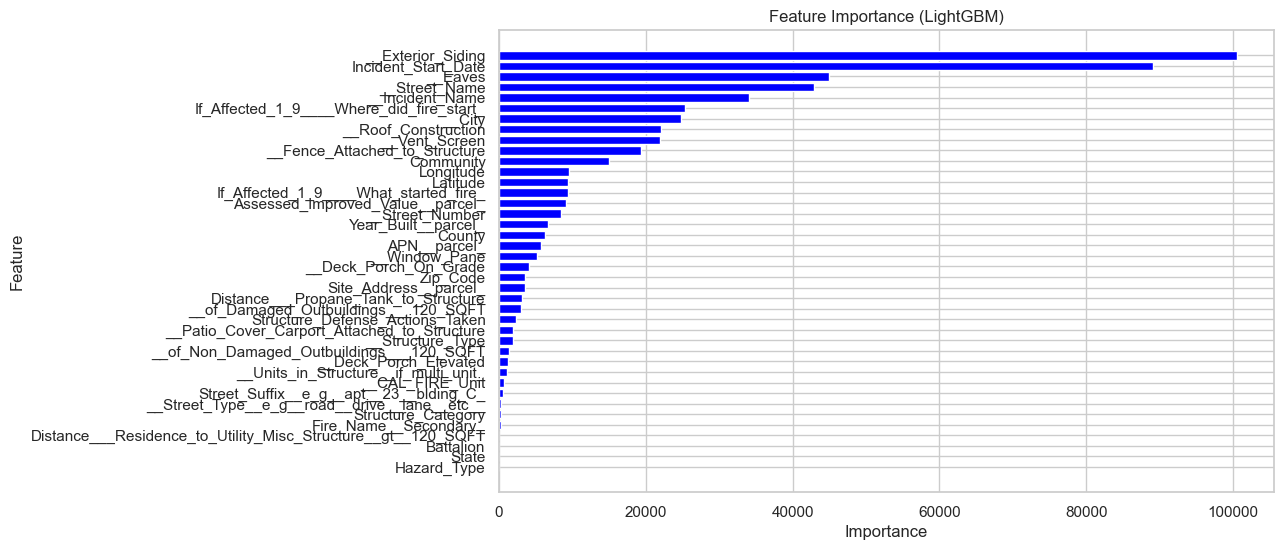

In [221]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='blue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

### Dropping Incident Start Date

In [236]:
top_features = feature_importance.head(21)['Feature'].tolist()
top_features.remove('Incident_Start_Date')
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]


In [237]:
X_train_selected

,__Exterior_Siding,__Eaves,__Street_Name,__Incident_Name,__Roof_Construction,If_Affected_1_9____Where_did_fire_start_,__Vent_Screen,__City,__Fence_Attached_to_Structure,Community,Latitude,Assessed_Improved_Value__parcel_,If_Affected_1_9____What_started_fire_,Longitude,__Deck_Porch_On_Grade,__Street_Number,Year_Built__parcel_,County,APN__parcel_,__Window_Pane
73298,Combustible,Unknown,Rocky Ridge,Soberanes,Combustible,NaN,Unknown,Unincorporated,NaN,NaN,36.390135,0.0,NaN,-121.836630,,0,NaN,Monterey,418161017000,Single Pane
13289,Wood,Enclosed,Langtry,Glass,Metal,Deck Elevated,No Vents,NaN,Combustible,Saint Helena,38.519103,786502.0,NaN,-122.528957,Masonry/Concrete,3551,1969.0,Napa,022140056000,Multi Pane
66284,Unknown,Unknown,Hill,Valley,Unknown,NaN,Unknown,Cobb,NaN,NaN,38.820328,95000.0,NaN,-122.698893,,0,NaN,Lake,05092102,Unknown
69027,Combustible,Unknown,West,Redwood,Fire Resistant,NaN,Unknown,Redwood City,NaN,Redwood valley,39.299452,217110.0,NaN,-123.219295,,10863,0.0,Mendocino,16009004,Single Pane
70973,Combustible,Unknown,Mott,Thomas,Fire Resistant,NaN,No Vents,Unincorporated,NaN,NaN,34.427130,0.0,NaN,-119.097124,,10149,1915.0,Ventura,040005103,Single Pane
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,Unknown,Unknown,Buckeye,Creek,Unknown,NaN,Unknown,NaN,Unknown,NaN,37.111306,0.0,NaN,-119.322082,Unknown,42220,0.0,Fresno,12011022SU,Unknown
54886,,,NaN,Camp,,NaN,,Unincorporated,NaN,NaN,39.820737,60835.0,NaN,-121.601992,,<NA>,1977.0,Butte,064-550-039-000,
76820,Unknown,Unknown,Chipmunk,Lava,Unknown,NaN,Unknown,Montague,Unknown,NaN,41.581015,NaN,NaN,-122.312331,Unknown,11867,NaN,Siskiyou,100-181-020,Unknown
860,Stucco Brick Cement,Unenclosed,Lawson valley,Valley,Asphalt,NaN,No Vents,NaN,No Fence,NaN,32.763139,45777.0,NaN,-116.759951,Masonry/Concrete,18390,0.0,San Diego,5211110400,Single Pane


In [238]:
# Create LightGBM Datasets
train_data = lgb.Dataset(X_train_selected, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(X_test_selected, label=y_test, free_raw_data=False)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 5,  # Number of classes
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,  # Correctly placed here
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'verbosity': -1,
        'random_state': 42
    }

    # Train the model
    model = lgb.train(
        params,
        train_data,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predict on the test set
    y_pred = model.predict(X_test_selected, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_model_2 = lgb.train(
    {**best_params, 'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1},
    train_data,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# Evaluate the final model
y_pred = final_model_2.predict(X_test_selected, num_iteration=final_model_2.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

[I 2025-02-11 18:47:01,154] A new study created in memory with name: no-name-90dd978a-7f58-4ae7-ad7f-603d862fd050
[I 2025-02-11 18:47:03,405] Trial 0 finished with value: 0.934899730619575 and parameters: {'num_leaves': 163, 'learning_rate': 0.2923213851534863, 'min_child_samples': 66, 'max_depth': 5, 'reg_alpha': 0.8098265186915741, 'reg_lambda': 0.2987010395186127, 'subsample': 0.6325191306593425, 'colsample_bytree': 0.7929887647181564}. Best is trial 0 with value: 0.934899730619575.
[I 2025-02-11 18:47:08,252] Trial 1 finished with value: 0.9369450264391899 and parameters: {'num_leaves': 60, 'learning_rate': 0.10305747139425747, 'min_child_samples': 32, 'max_depth': 9, 'reg_alpha': 0.6701456528216057, 'reg_lambda': 0.5366100504086877, 'subsample': 0.7210881658074549, 'colsample_bytree': 0.8511818954426356}. Best is trial 1 with value: 0.9369450264391899.
[I 2025-02-11 18:47:13,099] Trial 2 finished with value: 0.9368951411752968 and parameters: {'num_leaves': 76, 'learning_rate': 0.

Best Hyperparameters: {'num_leaves': 179, 'learning_rate': 0.1518391219056363, 'min_child_samples': 38, 'max_depth': 12, 'reg_alpha': 0.6833165460500475, 'reg_lambda': 0.070710597232521, 'subsample': 0.5443528071011696, 'colsample_bytree': 0.550855717357568}
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's multi_logloss: 0.227061
Accuracy: 0.9383916990920882
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      8261
           1       0.75      0.56      0.64       644
           2       0.18      0.04      0.07       206
           3       0.14      0.04      0.07       118
           4       0.95      0.96      0.96     10817

    accuracy                           0.94     20046
   macro avg       0.59      0.52      0.54     20046
weighted avg       0.93      0.94      0.93     20046



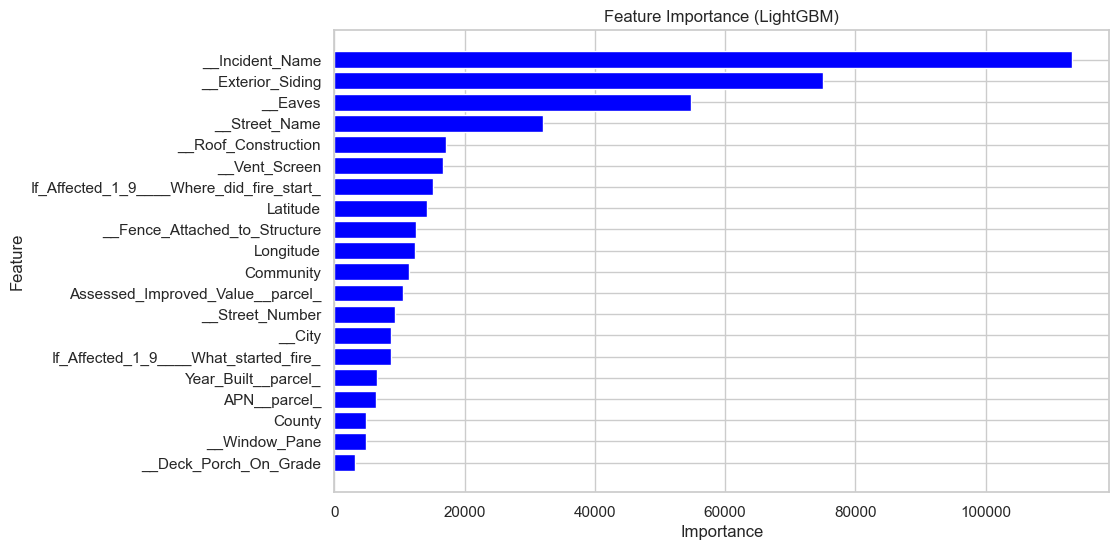

In [239]:
# Get feature importance scores
feature_importance = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': final_model_2.feature_importance(importance_type='gain')  # 'gain' is more reliable than 'split'
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='blue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

### Droping incident name

In [240]:
top_features = feature_importance.head(21)['Feature'].tolist()
top_features.pop(0)
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

In [241]:
X_train_selected

,__Exterior_Siding,__Eaves,__Street_Name,__Roof_Construction,__Vent_Screen,If_Affected_1_9____Where_did_fire_start_,Latitude,__Fence_Attached_to_Structure,Longitude,Community,Assessed_Improved_Value__parcel_,__Street_Number,__City,If_Affected_1_9____What_started_fire_,Year_Built__parcel_,APN__parcel_,County,__Window_Pane,__Deck_Porch_On_Grade
73298,Combustible,Unknown,Rocky Ridge,Combustible,Unknown,NaN,36.390135,NaN,-121.836630,NaN,0.0,0,Unincorporated,NaN,NaN,418161017000,Monterey,Single Pane,
13289,Wood,Enclosed,Langtry,Metal,No Vents,Deck Elevated,38.519103,Combustible,-122.528957,Saint Helena,786502.0,3551,NaN,NaN,1969.0,022140056000,Napa,Multi Pane,Masonry/Concrete
66284,Unknown,Unknown,Hill,Unknown,Unknown,NaN,38.820328,NaN,-122.698893,NaN,95000.0,0,Cobb,NaN,NaN,05092102,Lake,Unknown,
69027,Combustible,Unknown,West,Fire Resistant,Unknown,NaN,39.299452,NaN,-123.219295,Redwood valley,217110.0,10863,Redwood City,NaN,0.0,16009004,Mendocino,Single Pane,
70973,Combustible,Unknown,Mott,Fire Resistant,No Vents,NaN,34.427130,NaN,-119.097124,NaN,0.0,10149,Unincorporated,NaN,1915.0,040005103,Ventura,Single Pane,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,Unknown,Unknown,Buckeye,Unknown,Unknown,NaN,37.111306,Unknown,-119.322082,NaN,0.0,42220,NaN,NaN,0.0,12011022SU,Fresno,Unknown,Unknown
54886,,,NaN,,,NaN,39.820737,NaN,-121.601992,NaN,60835.0,<NA>,Unincorporated,NaN,1977.0,064-550-039-000,Butte,,
76820,Unknown,Unknown,Chipmunk,Unknown,Unknown,NaN,41.581015,Unknown,-122.312331,NaN,NaN,11867,Montague,NaN,NaN,100-181-020,Siskiyou,Unknown,Unknown
860,Stucco Brick Cement,Unenclosed,Lawson valley,Asphalt,No Vents,NaN,32.763139,No Fence,-116.759951,NaN,45777.0,18390,NaN,NaN,0.0,5211110400,San Diego,Single Pane,Masonry/Concrete


In [242]:
# Create LightGBM Datasets
train_data = lgb.Dataset(X_train_selected, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(X_test_selected, label=y_test, free_raw_data=False)

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 5,  # Number of classes
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,  # Correctly placed here
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'verbosity': -1,
        'random_state': 42
    }

    # Train the model
    model = lgb.train(
        params,
        train_data,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Predict on the test set
    y_pred = model.predict(X_test_selected, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_model_3 = lgb.train(
    {**best_params, 'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1},
    train_data,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
)

# Evaluate the final model
y_pred = final_model_3.predict(X_test_selected, num_iteration=final_model_3.best_iteration)
y_pred = np.argmax(y_pred, axis=1)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

[I 2025-02-11 19:02:12,153] A new study created in memory with name: no-name-0c052232-623c-4498-b224-d760f21eeeb7
[I 2025-02-11 19:02:16,856] Trial 0 finished with value: 0.9332036316472114 and parameters: {'num_leaves': 261, 'learning_rate': 0.1889985046913459, 'min_child_samples': 86, 'max_depth': 12, 'reg_alpha': 0.6829235755491346, 'reg_lambda': 0.7976340327485124, 'subsample': 0.7730978361564752, 'colsample_bytree': 0.897990685992603}. Best is trial 0 with value: 0.9332036316472114.
[I 2025-02-11 19:02:18,637] Trial 1 finished with value: 0.9241743988825701 and parameters: {'num_leaves': 127, 'learning_rate': 0.05769041352753781, 'min_child_samples': 69, 'max_depth': 4, 'reg_alpha': 0.6651337301582697, 'reg_lambda': 0.6215249061045075, 'subsample': 0.8644796174945022, 'colsample_bytree': 0.6282543987168719}. Best is trial 0 with value: 0.9332036316472114.
[I 2025-02-11 19:02:27,457] Trial 2 finished with value: 0.9343509927167515 and parameters: {'num_leaves': 146, 'learning_rate'

Best Hyperparameters: {'num_leaves': 215, 'learning_rate': 0.09225279849803905, 'min_child_samples': 37, 'max_depth': 12, 'reg_alpha': 0.6380376659750681, 'reg_lambda': 0.5158583274419029, 'subsample': 0.5144137979214481, 'colsample_bytree': 0.5001116045347076}
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's multi_logloss: 0.225592
Accuracy: 0.9367953706475107
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      8261
           1       0.74      0.55      0.63       644
           2       0.21      0.04      0.07       206
           3       0.19      0.04      0.07       118
           4       0.95      0.96      0.95     10817

    accuracy                           0.94     20046
   macro avg       0.61      0.51      0.54     20046
weighted avg       0.93      0.94      0.93     20046



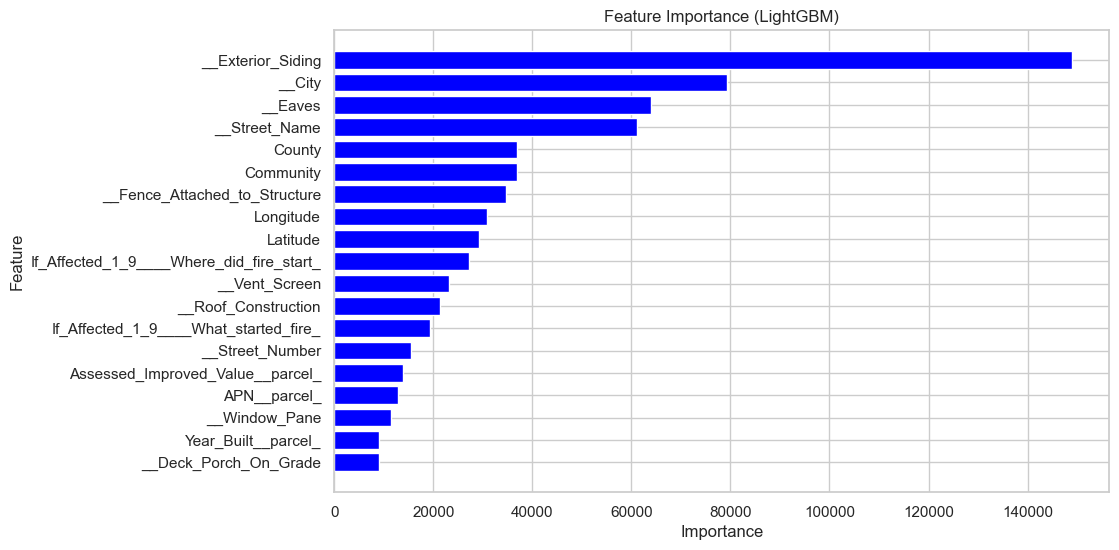

In [243]:
# Get feature importance scores
feature_importance = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importance': final_model_3.feature_importance(importance_type='gain')  # 'gain' is more reliable than 'split'
})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='blue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()